# Image recognition android application project
- Leaf image classification with Baseline CNN
- 626 training set with 3 class, 30 iterations, 1 batch
- Target size : (128, 128)
- Train accuracy : 98.40%, Val accuracy : 97.19%

## 0. Import Packages

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import tarfile
import glob
from six.moves import urllib
import random
import shutil
import imageio
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import tensorflow as tf

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


## 1. Convert png to jpg

In [2]:
def convert_jpg(dir, save_dir):
    
    data = []
    cat_list = os.listdir(dir)
    cat_len = len(os.listdir(dir))
    
    for cat in cat_list :
        
        category = os.listdir(dir + cat)
        i = 0
        for name in category :
            png = imageio.imread(dir + cat + '/' + name)
            png = Image.fromarray(png)
            png.load()  # for splitting

            # convert RGBA to RGB -> alpha channel
            if(len(png.split()) == 4):
                img = Image.new('RGB', png.size, (255, 255, 255)) # white
                img.paste(png, mask = png.split()[3])
            else:
                img = png

            img.save(save_dir + cat + '/' + str(i) + '.jpg')
            i += 1

In [14]:
dir = "data/"
cat_list = os.listdir(dir)
cat_len = len(os.listdir(dir))

print("The number of category :",cat_len)
print(cat_list)

The number of category : 3
['HR', 'normal', 'sick']


In [16]:
# Convert png to jpg
dir = "data/"
save_dir = "data_jpg/"
convert_jpg(dir, save_dir)

## 2. Explore dataset

In [32]:
def load_data_files(base_dir):
    folder_name = "data_jpg"

    abs_dir = os.path.join(os.getcwd(), folder_name)
    sub_dir = os.listdir(abs_dir)
    data_dic = {}
    cat_len = []
    for class_name  in sub_dir:
        imgs = glob.glob(os.path.join(abs_dir,class_name,"*.jpg"))

        data_dic[class_name] = imgs
        cat_len.append(len(imgs))
        print("Class: {}".format(class_name))
        print("Number of images: {} \n".format(len(imgs)))

    return data_dic, cat_len

In [33]:
BASE_DIR = os.getcwd()
data_dic, cat_len = load_data_files(BASE_DIR)

Class: HR
Number of images: 113 

Class: normal
Number of images: 324 

Class: sick
Number of images: 200 



In [34]:
def plot_image_grid(images_files):
    # figure size
    fig = plt.figure(figsize = (8, 8))

    # load images
    images = [tf.keras.preprocessing.image.load_img(img) for img in images_files]

    # plot image grid
    for x in range(4):
        ax = fig.add_subplot(1, 4, x+1)
        plt.imshow(images[x])
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

Seed type: HR


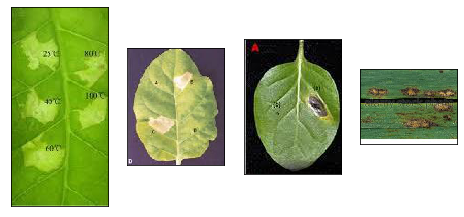

Seed type: normal


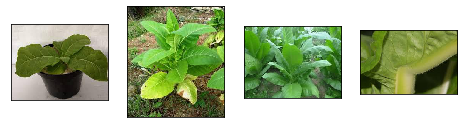

Seed type: sick


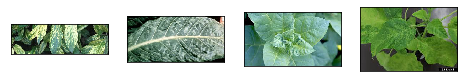

In [35]:
for class_name, imgs in data_dic.items():
    print("Seed type: {}".format(class_name))
    plot_image_grid(imgs[:16])

## 3. Make Dataset

In [36]:
# Create new directory and copy files to it
def copy_files_to_directory(files, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created directory: {}".format(directory))

    for f in files:
        shutil.copy(f, directory)
    print("Copied {} files.\n".format(len(files)))

In [37]:
def train_validation_split(base_dir, data_dic, split_ratio=0.2):
    FLOWER_DATASET = os.path.join(base_dir,"train_jpg")

    if not os.path.exists(FLOWER_DATASET):
        os.makedirs(FLOWER_DATASET)

    for class_name, imgs in data_dic.items():
        idx_split = int(len(imgs) * split_ratio)
        random.shuffle(imgs)
        validation = imgs[:idx_split]
        train = imgs[idx_split:]

        copy_files_to_directory(train, os.path.join(FLOWER_DATASET,"train",class_name))
        copy_files_to_directory(validation, os.path.join(FLOWER_DATASET,"validation",class_name))

In [39]:
BASE_DIR = os.getcwd()

train_validation_split(BASE_DIR, data_dic, split_ratio = 0.1)

Copied 102 files.

Copied 11 files.

Copied 292 files.

Copied 32 files.

Copied 180 files.

Copied 20 files.



## 4. Baseline CNN

In [4]:
# params
batch_size = 1
num_classes = 3
epochs = 30

In [14]:
preprocessing_image = tf.keras.preprocessing.image

train_datagen = preprocessing_image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = preprocessing_image.ImageDataGenerator(rescale=1./255)

In [15]:
BASE_DIR = os.getcwd()

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "train_jpg/train"),
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "train_jpg/validation"),
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical')

Found 626 images belonging to 3 classes.
Found 178 images belonging to 3 classes.


In [5]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='same',
                 activation='relu',
                 input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 64)      4864      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)             

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [18]:
%%time
hist50 = model.fit_generator(
    train_generator,
    steps_per_epoch=626//batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=10)

Epoch 1/30
626/626 [==============================] - 71s 114ms/step - loss: 1.0359 - accuracy: 0.5016 - val_loss: 0.9994 - val_accuracy: 0.3000
Epoch 2/30
626/626 [==============================] - 73s 117ms/step - loss: 1.0125 - accuracy: 0.5016 - val_loss: 2.4390 - val_accuracy: 0.5000
Epoch 3/30
626/626 [==============================] - 75s 119ms/step - loss: 0.9808 - accuracy: 0.5112 - val_loss: 1.5540 - val_accuracy: 0.5000
Epoch 4/30
626/626 [==============================] - 74s 119ms/step - loss: 0.9493 - accuracy: 0.5431 - val_loss: 0.6447 - val_accuracy: 0.4000
Epoch 5/30
626/626 [==============================] - 63s 101ms/step - loss: 0.9208 - accuracy: 0.5559 - val_loss: 0.9606 - val_accuracy: 0.5000
Epoch 6/30
626/626 [==============================] - 72s 115ms/step - loss: 0.8692 - accuracy: 0.6022 - val_loss: 0.4809 - val_accuracy: 1.0000
Epoch 7/30
626/626 [==============================] - 73s 117ms/step - loss: 0.8139 - accuracy: 0.6118 - val_loss: 0.6980 - val_ac

In [19]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Baseline CNN Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Baseline CNN loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

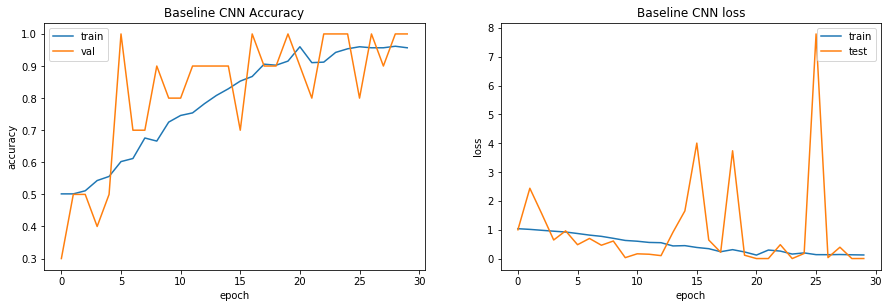

In [20]:
plot_accuracy_and_loss(hist50)

In [21]:
print("-- Evaluate --")

scores_train = model.evaluate_generator(
            train_generator)
scores_val = model.evaluate_generator(
            validation_generator)

print("Train " + "%s: %.2f%%" %(model.metrics_names[1], scores_train[1]*100))
print("Val " + "%s: %.2f%%" %(model.metrics_names[1], scores_val[1]*100))

print("-- Predict --")
output_train = model.predict_generator(train_generator, steps=5)
output_val = model.predict_generator(validation_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print(train_generator.class_indices)
print(output_train)

print(validation_generator.class_indices)
print(output_val)

-- Evaluate --
Train accuracy: 98.40%
Val accuracy: 97.19%
-- Predict --
{'HR': 0, 'normal': 1, 'sick': 2}
[[0.032 0.001 0.967]
 [0.009 0.991 0.000]
 [0.002 0.857 0.141]
 [0.000 0.489 0.511]
 [0.001 0.004 0.995]]
{'HR': 0, 'normal': 1, 'sick': 2}
[[0.000 0.000 1.000]
 [0.000 0.000 1.000]
 [0.002 0.995 0.002]
 [0.001 0.999 0.001]
 [0.027 0.973 0.000]]


In [22]:
# save model architecture
model_json = model.to_json()
open('baseline_CNN_with_moredata30.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('baseline_CNN_weight_with_moredata30.h5', overwrite=True)

In [25]:
# Load trained model
from keras.models import model_from_json 

json_file = open("model/baseline_CNN_with_moredata30.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)
 
# model weight load 
loaded_model.load_weights("model/baseline_CNN_weight_with_moredata30.h5")
print("Loaded model from disk")

Loaded model from disk


## 5. Visualization of filters

In [26]:
loaded_model.summary()
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'], run_eagerly=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 64)      4864      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)             

CONV1
Conv shape : (5, 5, 3, 64)


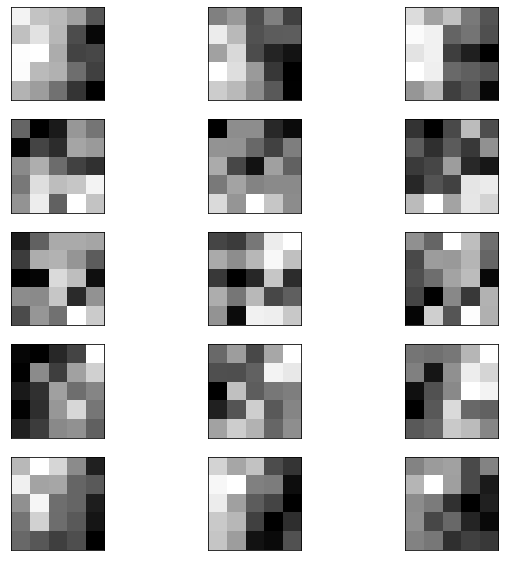

In [29]:
weights = loaded_model.get_weights()
conv1_w = weights[0]
conv1_b = weights[1]

conv2_w = weights[2]
conv2_b = weights[3]

conv3_w = weights[4]
conv3_b = weights[5]

f_min, f_max = conv1_w.min(), conv1_w.max()
conv1_w = (conv1_w - f_min) / (f_max - f_min)

n_filters, ix = 5, 1  ## changable
plt.figure(figsize=(10,10))

print("CONV1")
print("Conv shape :", np.shape(conv1_w))
for i in range(n_filters):
    # get the filter
    f = conv1_w[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax1 = pyplot.subplot(n_filters, 3, ix)
        ax1.set_xticks([])
        ax1.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.savefig("Conv1.jpg")
pyplot.show()

CONV2
Conv shape : (3, 3, 64, 64)


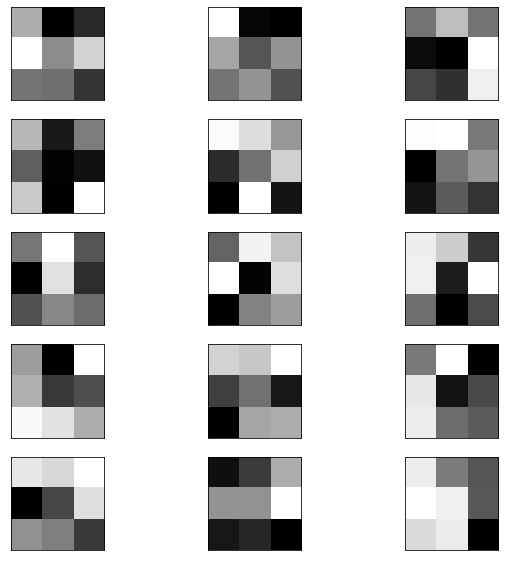

In [30]:
n_filters, ix = 5, 1  ## changable
plt.figure(figsize=(10,10))
print("CONV2")
print("Conv shape :", np.shape(conv2_w))
for i in range(n_filters):
    # get the filter
    f = conv2_w[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax2 = pyplot.subplot(n_filters, 3, ix)
        ax2.set_xticks([])
        ax2.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.savefig("Conv2.jpg")
pyplot.show()

CONV3
Conv shape : (3, 3, 64, 32)


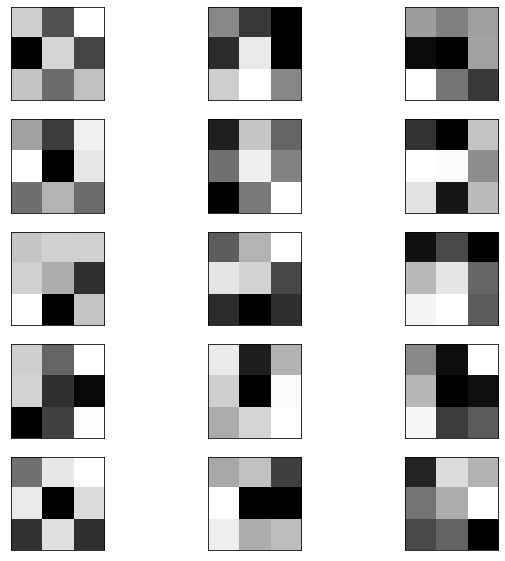

In [31]:
n_filters, ix = 5, 1  ## changable
plt.figure(figsize=(10,10))
print("CONV3")
print("Conv shape :", np.shape(conv3_w))
for i in range(n_filters):
    # get the filter
    f = conv3_w[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax3 = pyplot.subplot(n_filters, 3, ix)
        ax3.set_xticks([])
        ax3.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.savefig("Conv3.jpg")
pyplot.show()

## 6. Visualization of feature maps

In [40]:
# redefine model to output right after the first hidden layer
model = Model(inputs=loaded_model.inputs, outputs=loaded_model.layers[1].output)

In [51]:
img_HR = load_img('HR_sample.jpg', target_size=(128, 128))
img_normal = load_img('normal_sample.jpg', target_size=(128, 128))
img_sick = load_img('sick_sample.jpg', target_size=(128, 128))

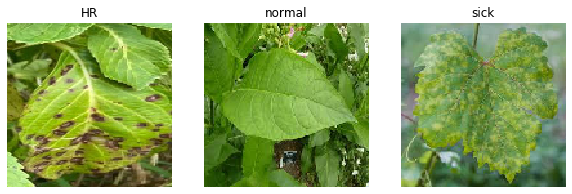

In [42]:
plt.figure(figsize=(10,15))

plt.subplot(1,3,1)
plt.imshow(img_HR)
plt.title("HR")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(img_normal)
plt.title("normal")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_sick)
plt.title("sick")
plt.axis("off")
plt.savefig("samples.jpg")
plt.show()

In [52]:
img_HR = np.array(img_HR)
img_normal = np.array(img_normal)
img_sick = np.array(img_sick)

img_HR = expand_dims(img_HR, axis=0)
img_normal = expand_dims(img_normal, axis=0)
img_sick = expand_dims(img_sick, axis=0)

img_HR = preprocess_input(img_HR)
img_normal = preprocess_input(img_normal)
img_sick = preprocess_input(img_sick)

feature_maps_HR = model.predict(img_HR)
feature_maps_normal = model.predict(img_normal)
feature_maps_sick = model.predict(img_sick)

## 6-1. First Conv layer feature maps

HR


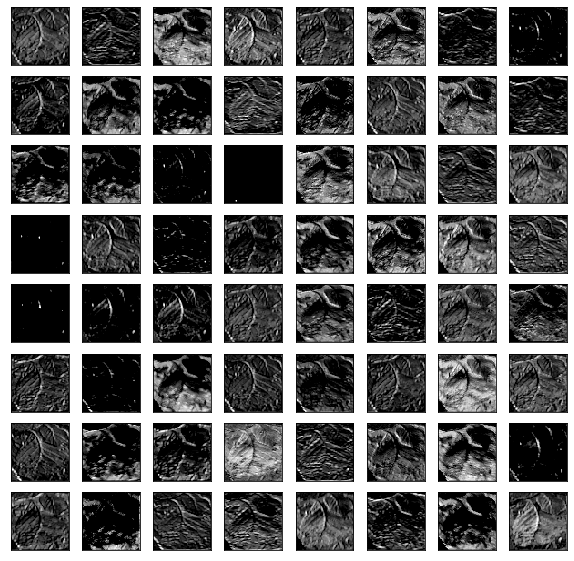

In [38]:
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(10,10))
print("HR")
for _ in range(square):
    for _ in range(square):
    # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps_HR[0, :, :, ix-1], cmap = 'gray')
        ix += 1
# show the figure
pyplot.show()

## 6-2. ALL Conv layer feature maps

1


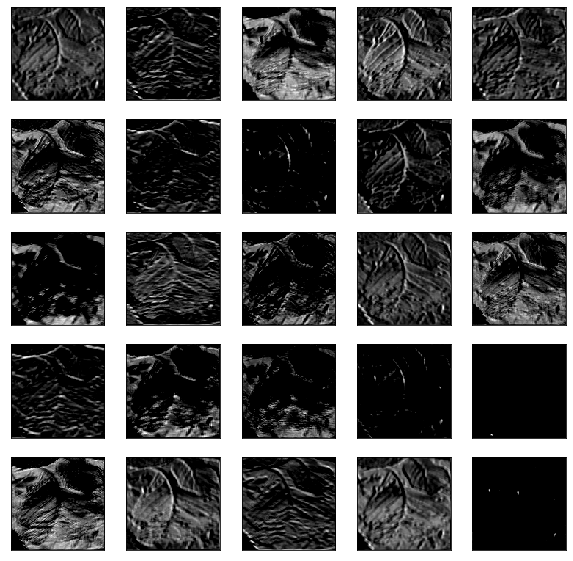

2


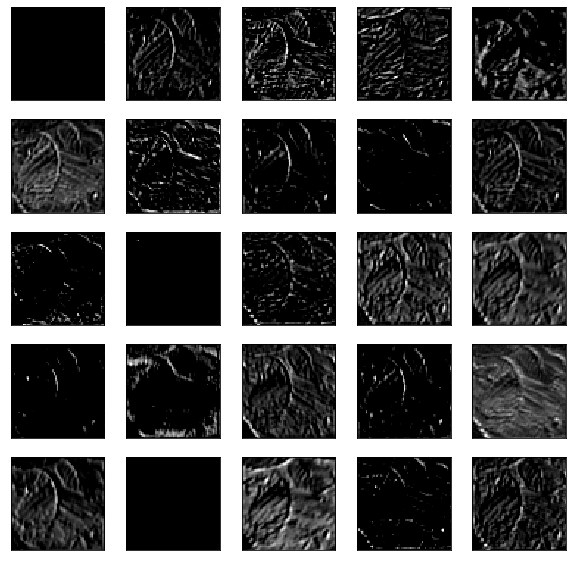

3


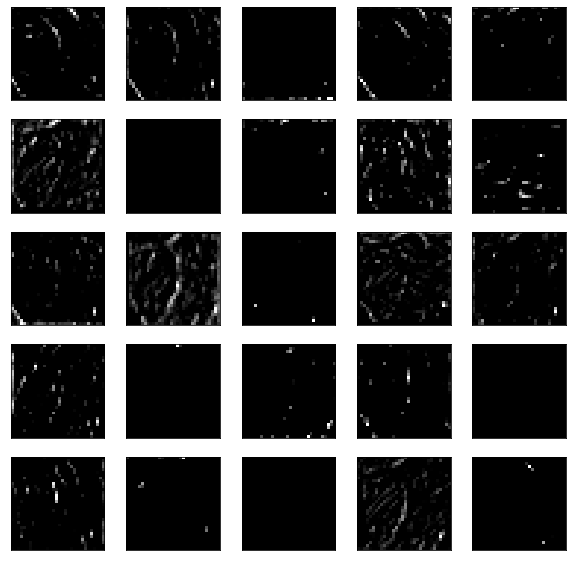

In [54]:
ixs = [0,2,4]
outputs = [loaded_model.layers[i].output for i in ixs]
model = Model(inputs=loaded_model.inputs, outputs=outputs)

feature_maps = model.predict(img_HR)

# plot the output from each block
square = 5
iy = 0
for fmap in feature_maps:
    plt.figure(figsize=(10,10))
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
        # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
     
    iy+=1
    print(iy)
    plt.savefig("Featuremap" + str(iy) + '.jpg')
    # show the figure
    pyplot.show()